In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP & CONSTANTS
# ==========================================
folders = [f"mp_IHC3000_A{i:02d}" for i in range(1, 11)]

# Frequencies in Hz
highHz_all = np.array([3900, 6000, 8000, 10300, 12000, 14500, 16000])
lowHz_all  = np.array([3800, 5800, 7500, 10000, 13200, 15300])

# Fixed conditions
FIXED_NOISE_HIGH_FOR_LOW_LOOP = 20000
FIXED_NOISE_LOW_FOR_HIGH_LOOP = 20

# Storage for results: Shape will be (N_archs, N_freqs)
nmi_low_archs = []
nmi_high_archs = []
r2_low_archs = []
r2_high_archs = []

# ==========================================
# 2. CALCULATION LOOP
# ==========================================
def compute_metrics_high_dim(X_data, labels):
    if len(X_data) < 10: return np.nan, np.nan
    
    # NMI
    n_classes = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_classes, random_state=0, n_init=10)
    labels_pred = kmeans.fit_predict(X_data)
    nmi = normalized_mutual_info_score(labels, labels_pred)
    
    # R2
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, labels, test_size=0.2, random_state=42
        )
        # decoder = Ridge(alpha=1.0)
        decoder = LinearRegression()
        decoder.fit(X_train, y_train)
        y_pred = decoder.predict(X_train)
        r2 = r2_score(y_train, y_pred)
    except:
        r2 = np.nan
    return nmi, r2

print("Computing High-D metrics across architectures...")

for folder in tqdm(folders):
    # Temp lists for this specific architecture
    curr_nmi_low, curr_r2_low = [], []
    curr_nmi_high, curr_r2_high = [], []
    
    try:
        # Load
        path_X = f"{folder}/mp_all_emb_penultimate_512.npy"
        path_azim = f"mp_all_azim.npy"
        path_elev = f"mp_all_elev.npy"
        path_nHigh = f"mp_all_noise_high.npy"
        path_nLow = f"mp_all_noise_low.npy"
        
        X_raw = np.load(path_X)
        azim_labels = np.squeeze(np.load(path_azim))
        elev_labels = np.squeeze(np.load(path_elev))
        noiseHigh = np.squeeze(np.load(path_nHigh))
        noiseLow = np.squeeze(np.load(path_nLow))
        
        # Filter Azimuth 0 & Normalize
        mask_base = (azim_labels == 0)
        X_base = normalize(X_raw[mask_base], norm='l2') # <--- High-D L2 Norm
        elev_base = elev_labels[mask_base]
        nHigh_base = noiseHigh[mask_base]
        nLow_base = noiseLow[mask_base]

        # --- A. Low Pass Loop (Vary LowHz) ---
        for val in lowHz_all:
            mask = (nLow_base == val) & (nHigh_base == FIXED_NOISE_HIGH_FOR_LOW_LOOP)
            nmi, r2 = compute_metrics_high_dim(X_base[mask], elev_base[mask])
            curr_nmi_low.append(nmi)
            curr_r2_low.append(r2)
            
        # --- B. High Pass Loop (Vary HighHz) ---
        for val in highHz_all:
            mask = (nHigh_base == val) & (nLow_base == FIXED_NOISE_LOW_FOR_HIGH_LOOP)
            nmi, r2 = compute_metrics_high_dim(X_base[mask], elev_base[mask])
            curr_nmi_high.append(nmi)
            curr_r2_high.append(r2)
            
        # Append to main lists
        nmi_low_archs.append(curr_nmi_low)
        r2_low_archs.append(curr_r2_low)
        nmi_high_archs.append(curr_nmi_high)
        r2_high_archs.append(curr_r2_high)
        
    except Exception as e:
        print(f"Error in {folder}: {e}")

# Convert to numpy arrays for easy math
nmi_low_archs = np.array(nmi_low_archs)   # (10, 6)
r2_low_archs  = np.array(r2_low_archs)    # (10, 6)
nmi_high_archs = np.array(nmi_high_archs) # (10, 7)
r2_high_archs  = np.array(r2_high_archs)  # (10, 7)

# Convert x-axis to kHz for plotting
freq_low_khz = lowHz_all / 1000.0
freq_high_khz = highHz_all / 1000.0

Computing High-D metrics across architectures...


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.76s/it]


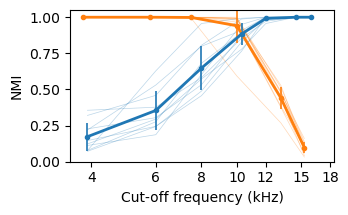

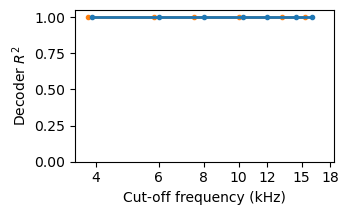

In [10]:
# ==========================================
# 3. PLOTTING FUNCTION
# ==========================================
def plot_metrics(low_data, high_data, ylabel_text, filename):
    
    # Statistics
    mean_low  = np.nanmean(low_data, axis=0)
    std_low   = np.nanstd(low_data, axis=0)
    mean_high = np.nanmean(high_data, axis=0)
    std_high  = np.nanstd(high_data, axis=0)

    fig, ax = plt.subplots(figsize=(3.5, 2.25))

    # --- Individual architectures (Low - Blue) ---
    for i in range(low_data.shape[0]):
        ax.plot(freq_low_khz, low_data[i], marker="o", linewidth=0.5, markersize=0,
                alpha=0.3, color="C1")

    # --- Individual architectures (High - Orange) ---
    for i in range(high_data.shape[0]):
        ax.plot(freq_high_khz, high_data[i], marker="o", linewidth=0.5, markersize=0,
                alpha=0.3, color="C0")

    # --- Mean ± SD (Low) ---
    ax.errorbar(freq_low_khz, mean_low, yerr=std_low, fmt="o-", linewidth=2,
                color="C1", ecolor="C1", elinewidth=1.2, markersize=3, capsize=0, 
                label="High pass")

    # --- Mean ± SD (High) ---
    ax.errorbar(freq_high_khz, mean_high, yerr=std_high, fmt="o-", linewidth=2,
                color="C0", ecolor="C0", elinewidth=1.2, markersize=3, capsize=0, 
                label="Low pass")

    # Formatting
    ax.set_xscale("log", base=2)
    xticks = np.array([4, 6, 8, 10, 12, 15, 18], dtype=np.int32)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) for x in xticks])
    
    ax.set_xlim(3.5, 18.5)
    ax.set_ylim(0, 1.05) # Keep 0-1 range roughly
    ax.set_xlabel("Cut-off frequency (kHz)")
    ax.set_ylabel(ylabel_text)
    
    # Legend only on first plot or if needed
    # if "NMI" in ylabel_text:
    #     ax.legend(frameon=False, fontsize=8)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# 4. GENERATE PLOTS
# ==========================================

# Plot NMI
plot_metrics(nmi_low_archs, nmi_high_archs, "NMI", "Results_NMI_HighD.pdf")

# Plot R2
plot_metrics(r2_low_archs, r2_high_archs, "Decoder $R^2$", "Results_R2_HighD.pdf")